<a href="https://colab.research.google.com/github/guswns3396/PSYC-221-Project/blob/main/Segment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls

brainmetshare-3  cache_dir  README.md  requirements.txt  Segment.ipynb


# Install & Import Dependencies

In [25]:
import logging
import os
import sys
from glob import glob
from abc import ABC, abstractmethod

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import nibabel as nib

import monai
import monai.transforms as mt
from monai.data import PersistentDataset, Dataset, DataLoader, decollate_batch
from monai.apps import CrossValidation
from monai.inferers import sliding_window_inference
from monai.utils import set_determinism

import torch

In [3]:
os.cpu_count()

20

In [4]:
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
available_gpus

[]

In [5]:
set_determinism(seed=0)

In [6]:
!pwd

/home/users/yanghyun/psyc221


In [7]:
root_dir = '/home/users/yanghyun/psyc221'

# Get Data

In [8]:
IMG_TYPES = {
  'bravo': 0,
  'flair': 1,
  't1_gd': 2,
  't1_pre': 3
}

In [9]:
def get_data_dicts(path):
    data = [
    {
      'img': [os.path.join(subj, img_type + '.nii.gz') for img_type in IMG_TYPES],
      'seg': os.path.join(subj, 'seg.nii.gz')
    }
    for subj in glob(os.path.join(path, 'Mets_*'))
    ]
    return data

In [11]:
def fix_meta(metatensor):
    """
    fix meta information of metatensor after stacking
    """
    # fix img meta
    a = [metatensor.ndim, *metatensor.shape[1:], metatensor.shape[0]]
    for i, val in enumerate(a):
        metatensor.meta['dim'][i] = val
        metatensor.meta['original_channel_dim'] = -1
    return metatensor

In [12]:
def print_data(metatensor):
    print(metatensor.shape)
    print(metatensor.meta)
    return metatensor

In [13]:
path_train = os.path.join(root_dir, 'brainmetshare-3/train')

In [14]:
data_dicts = get_data_dicts(path_train)

# Data Exploration

In [15]:
train_ds = Dataset(
  data_dicts,
  transform=mt.Compose([
    # load images
    mt.LoadImageD(['img', 'seg']),
  ])
)

In [16]:
def get_imbalance(ds):
    ones = 0
    zeroes = 0
    for d in tqdm(ds):
        ones += (d['seg'] == 1).sum()
        zeroes += (d['seg'] == 0).sum()
    return zeroes / ones

In [17]:
# # look at imbalance of classes
# ratio = get_imbalance(train_ds)
# ratio

In [18]:
ratio = torch.Tensor([2500])
ratio

tensor([2500.])

# Load & Pre-Process Data

In [19]:
KEYS = ('img', 'seg')
k = 4 # divisible

xform_train = mt.Compose([
    # load images
    mt.LoadImageD(KEYS),
    # make channel the first dimension / add channel dimension if necessary
    mt.EnsureChannelFirstD(KEYS),
    # fix meta
    mt.LambdaD(KEYS, fix_meta),
    # print data to ensure fix
    # mt.LambdaD(KEYS, print_data),
    # make sure tensor type
    mt.EnsureTypeD(keys=KEYS),
    # make sure all have same orientation (axcode)
    mt.Orientationd(keys=KEYS, axcodes="RAS"),
    mt.Spacingd(
      keys=KEYS,
      pixdim=(1.0, 1.0, 1.0),
      mode=("bilinear", "nearest"),
    ),
    # augment data to be invariant to orientation
    # mt.RandFlipd(keys=KEYS, prob=0.5, spatial_axis=0),
    # mt.RandFlipd(keys=KEYS, prob=0.5, spatial_axis=1),
    # mt.RandFlipd(keys=KEYS, prob=0.5, spatial_axis=2),
    # normalize intensity
    mt.NormalizeIntensityd(keys="img", nonzero=True, channel_wise=True),
    # augment data to be invariant to intensity shift or scale
    # mt.RandScaleIntensityd(keys="img", factors=0.1, prob=0.1),
    # mt.RandShiftIntensityd(keys="img", offsets=0.1, prob=0.1),
    # pad data to be divisible
    mt.DivisiblePadD(keys=KEYS, k=k),
])

xform_val = mt.Compose([
    # load images
    mt.LoadImageD(KEYS),
    # make channel the first dimension / add channel dimension if necessary
    mt.EnsureChannelFirstD(KEYS),
    # fix meta
    mt.LambdaD(KEYS, fix_meta),
    # print data to ensure fix
    # mt.LambdaD(KEYS, print_data),
    # make sure tensor type
    mt.EnsureTypeD(keys=KEYS),
    # make sure all have same orientation (axcode)
    mt.Orientationd(keys=KEYS, axcodes="RAS"),
    mt.Spacingd(
      keys=KEYS,
      pixdim=(1.0, 1.0, 1.0),
      mode=("bilinear", "nearest"),
    ),
    # normalize intensity
    mt.NormalizeIntensityd(keys="img", nonzero=True, channel_wise=True),
    # pad data to be divisible
    mt.DivisiblePadD(keys=KEYS, k=k),
])

In [20]:
# use PersistentDataset so deterministic preprocessing operations aren't repeated
# slow initialization, fast retrieval
# cache stored in disk not memory
class MRIDataset(ABC, PersistentDataset):
    """
    Base class to generate cross validation datasets.
    """

    def __init__(
        self,
        data,
        transform,
        **kwargs
    ) -> None:
        data = self._split_datalist(datalist=data)
        super().__init__(data, transform, **kwargs)

    @abstractmethod
    def _split_datalist(self, datalist):
        raise NotImplementedError(f"Subclass {self.__class__.__name__} must implement this method.")

In [21]:
# k-fold cross validation
num = 2
folds = list(range(num))

cache_dir = os.path.join(root_dir, 'cache_dir')

cvdataset = CrossValidation(
    dataset_cls=MRIDataset,
    data=data_dicts[:2], # subset data for Colab
    nfolds=num,
    transform=xform_train,
    cache_dir=cache_dir
)

In [22]:
# clear cache
for c in glob(os.path.join(cache_dir, '*')):
    os.remove(c)

In [23]:
num_workers=0
batch_size=1

# get datasets
train_dss = [cvdataset.get_dataset(folds=folds[0:i] + folds[(i + 1) :]) for i in folds]
val_dss = [cvdataset.get_dataset(folds=i, transform=xform_val) for i in folds]

# get loaders & set batch size, number of workers, shuffle
train_loaders = [DataLoader(train_dss[i], batch_size=batch_size, shuffle=True, num_workers=num_workers) for i in folds]
val_loaders = [DataLoader(val_dss[i], batch_size=batch_size, num_workers=num_workers) for i in folds]

# Visualize Data

subject: /home/users/yanghyun/psyc221/brainmetshare-3/train/Mets_146/bravo.nii.gz
image shape: torch.Size([4, 240, 240, 152])
segment shape: torch.Size([1, 240, 240, 152])


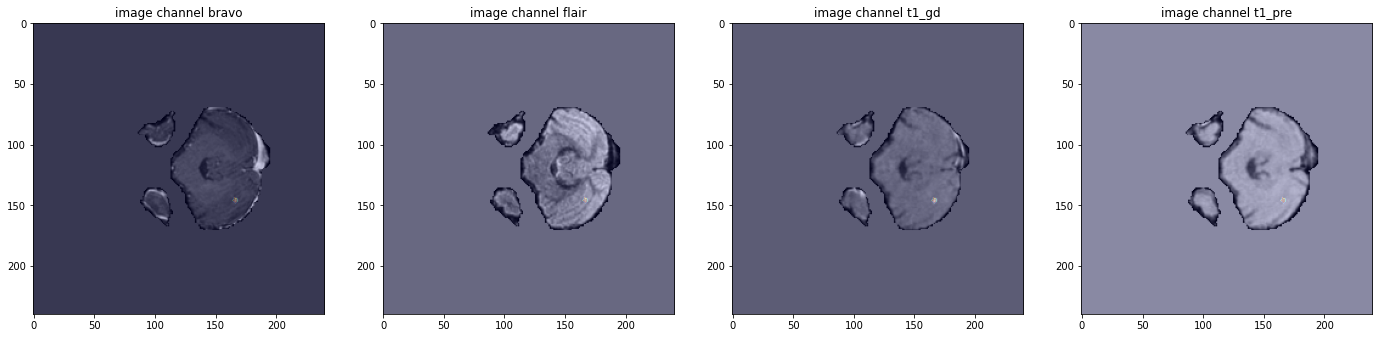

In [28]:
ds_idx = 0
subj_idx = 0

data = train_dss[ds_idx][subj_idx]
slice_id = np.argmax(data['seg'][0].sum(axis=[0,1])) # slice with most metastases

# visualize a slice from each image modality with segmentation overlay
print(f"subject: {data['img'].meta['filename_or_obj']}")
print(f"image shape: {data['img'].shape}")
print(f"segment shape: {data['seg'].shape}")
plt.figure("image", (24, 6))
for i, img_type in enumerate(IMG_TYPES):
    plt.subplot(1, len(IMG_TYPES), i + 1)
    plt.title(f"image channel {img_type}")
    plt.imshow(data['img'][IMG_TYPES[img_type], :, :, slice_id].detach().cpu(),  cmap="gray")
    plt.imshow(data['seg'][0, :, :, slice_id].detach().cpu(), cmap='jet', alpha=0.2) # interpolation='none'
plt.show()

# Implement Model

In [29]:
# class Spec:
#   def __init__(self, constr, **kwargs):
#     self.constr = constr
#     self.kwargs = kwargs

#   def __call__(self):
#     raise NotImplementedError

# class ModelSpec(Spec):
#   def __init__(self, const, **kwargs):
#     super().__init__(const, **kwargs)
#   def __call__(self):
#     return self.constr(**self.kwargs)

# class LossSpec(Spec):
#   def __init__(self, const, **kwargs):
#     super().__init__(const, **kwargs)
#   def __call__(self):
#     return self.constr(**self.kwargs)

# class OptSpec(Spec):
#   def __init__(self, const, **kwargs):
#     super().__init__(const, **kwargs)
#   def __call__(self, params):
#     return self.constr(params=params, **self.kwargs)

# class SpecComb:
#   def __init__(self, model_spec, loss_spec, opt_spec):
#     self.model_spec = model_spec
#     self.loss_spec = loss_spec
#     self.opt_spec = opt_spec

#   def __call__(self):
#     model = self.model_spec().to(device)
#     loss = self.loss_spec()
#     opt = self.opt_spec(model.parameters())

#     return model, loss, opt

In [30]:
# spec_combs = []

In [31]:
# spec_comb = SpecComb(
#   ModelSpec(
#       monai.networks.nets.UNet,
#       # 3D
#       spatial_dims=3,
#       # 4 modalities
#       in_channels=4,
#       # 1 channel for output
#       out_channels=1,
#       # layers
#       channels=(16, 32),
#       strides=(2,),
#       kernel_size=3,
#       up_kernel_size=3,
#       # num_res_units=2,
#       act='PRELU',
#       # norm=monai.networks.layers.Norm.BATCH,
#       # dropout=0,
#       # bias=True,
#       adn_ordering='NDA'
#   ),
#   LossSpec(
#       monai.losses.DiceLoss
#   ),
#   OptSpec(
#       torch.optim.Adam,
#       lr=1e-2
#   )
# )

In [32]:
# spec_combs.append(spec_comb)

# Training

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [38]:
max_epochs = 10
val_interval = 1 # validate every val_interval epochs
save_interval = 5 # save checkpoint every save_interval epochs
checkpoint_path = os.path.join(root_dir, 'model_checkpoint.pt')

roi_size = (120, 120, 76)
sw_batch_size = 4

post_pred = mt.Compose([mt.Activations(sigmoid=True), mt.AsDiscrete(threshold=0.5)])
post_label = mt.Compose([mt.AsDiscrete()])

[decollate_batch](https://github.com/Project-MONAI/tutorials/blob/main/modules/decollate_batch.ipynb)

In [39]:
# configure network
model = monai.networks.nets.UNet(
    spatial_dims=3, # 3D
    in_channels=4, # 4 modalities
    out_channels=1, # 1 channel for output
    channels=(16, 32), # layers
    strides=(2,),
    kernel_size=3,
    up_kernel_size=3,
    # num_res_units=2,
    act='PRELU',
    # norm=monai.networks.layers.Norm.BATCH,
    # dropout=0,
    # bias=True,
    adn_ordering='NDA'
).to(device)
# set loss, optimizer, metric
# loss_function = monai.losses.DiceCELoss(sigmoid=True, weight=ratio)
loss_function = torch.nn.BCEWithLogitsLoss(weight=ratio)
optimizer = torch.optim.Adam(model.parameters(), 1e-2)
metric_function = monai.metrics.DiceMetric(include_background=False, reduction="mean")

In [40]:
print(model)

UNet(
  (model): Sequential(
    (0): Convolution(
      (conv): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (adn): ADN(
        (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (1): SkipConnection(
      (submodule): Convolution(
        (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (adn): ADN(
          (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (D): Dropout(p=0.0, inplace=False)
          (A): PReLU(num_parameters=1)
        )
      )
    )
    (2): Convolution(
      (conv): ConvTranspose3d(48, 1, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(1, 1, 1))
    )
  )
)


In [41]:
# initialize variables for tracking
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

# iterate over epochs
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    # set to train mode
    model.train()
    # initialize loss
    epoch_loss = 0
    step = 0

    # batch train
    for batch_data in train_loaders[0]:
        step += 1
        # load data & move to device
        inputs, labels = (
            batch_data["img"].to(device),
            batch_data["seg"].to(device),
        )
        # zero grad
        optimizer.zero_grad()
        # forward pass
        outputs = model(inputs)
        # get loss
        loss = loss_function(outputs, labels)
        # backward pass
        loss.backward()
        # update weights
        optimizer.step()
        # running loss for epoch
        epoch_loss += loss.item()
        print(f"{step}/{len(train_dss[0]) // train_loaders[0].batch_size}, " f"train_loss: {loss.item():.4f}")
    # average loss over batches for epoch
    epoch_loss /= step
    # track epoch losses
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # save checkpoint
    if (epoch + 1) % save_interval == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, checkpoint_path)

    # validate
    if (epoch + 1) % val_interval == 0:
        # set model to evaulation mode
        model.eval()
        # disable gradiant computation
        with torch.no_grad():
            # iterate over validation data
            for val_data in val_loaders[0]:
                # load validation data
                val_inputs, val_labels = (
                    val_data["img"].to(device),
                    val_data["seg"].to(device),
                )
                # get output using sliding window inference
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model, overlap=0.25)
                # turn batch into list of images
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                metric_function(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = metric_function.aggregate().item()
            # reset the status for next validation round
            metric_function.reset()
            # track final metric result
            metric_values.append(metric)

            # update model if better performance
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/10
1/1, train_loss: 1875.3152
epoch 1 average loss: 1875.3152
saved new best metric model
current epoch: 1 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 1
----------
epoch 2/10
1/1, train_loss: 1518.1647
epoch 2 average loss: 1518.1647
current epoch: 2 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 1
----------
epoch 3/10
1/1, train_loss: 1213.5214
epoch 3 average loss: 1213.5214
current epoch: 3 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 1
----------
epoch 4/10
1/1, train_loss: 986.9578
epoch 4 average loss: 986.9578
current epoch: 4 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 1
----------
epoch 5/10
1/1, train_loss: 812.7288
epoch 5 average loss: 812.7288
current epoch: 5 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 1
----------
epoch 6/10
1/1, train_loss: 680.5725
epoch 6 average loss: 680.5725
current epoch: 6 current mean dice: 0.0000
best mean dice: 0.0000 at epoch: 1
----------
epoch 7/10
1/

In [42]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.0000 at epoch: 1


In [ ]:
# Delete cache
import shutil
shutil.rmtree(cache_dir)

# Plot Loss & Metric

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

# Inference

In [ ]:
input = ...

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    input = input.to(device)
    output = sliding_window_inference(input, roi_size, sw_batch_size, model, overlap=0.25)
    output = post_pred(output)